In [1]:
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt

In [2]:
#connect my db with sql database
conn = sqlite3.connect('superstore_database.db')
cursor = conn.cursor()

In [15]:
sql_query = """
    select c.CustomerName, c.State, count(*) from customers c 
    join orders o on c.CustomerID = o.CustomerID join sales s on o.OrderID=s.OrderID group by  c.CustomerName order by count(*) desc limit 10 
"""
pd.read_sql(sql_query, conn)

,CustomerName,State,count(*)
0,William Brown,Pennsylvania,37
1,Paul Prost,Georgia,34
2,Matt Abelman,Texas,34
3,John Lee,California,34
4,Seth Vernon,Delaware,32
5,Jonathan Doherty,Pennsylvania,32
6,Edward Hooks,New York,32
7,Chloris Kastensmidt,Pennsylvania,32
8,Zuschuss Carroll,Oregon,31
9,Emily Phan,Illinois,31


In [14]:
sql_query = """
    select c.CustomerName, c.State, count(*) from customers c 
    join orders o on c.CustomerID = o.CustomerID join sales s on o.OrderID=s.OrderID group by  c.State order by count(*) desc limit 10 
"""
pd.read_sql(sql_query, conn)

,CustomerName,State,count(*)
0,Darrin Van Huff,California,1998
1,Janet Molinari,New York,1110
2,Harold Pawlan,Texas,917
3,Sandra Flanagan,Pennsylvania,641
4,Linda Cazamias,Illinois,574
5,Ryan Crowe,Ohio,480
6,Irene Maddox,Washington,460
7,Andrew Allen,North Carolina,343
8,Brendan Sweed,Arizona,301
9,Sean O'Donnell,Florida,290


In [34]:
most_sales = """ 
select  c.State, sum(s.sales) as total_sales from customers c 
    join orders o on c.CustomerID = o.CustomerID join sales s on o.OrderID=s.OrderID  group by c.State order by sum(s.Sales) DESC limit 5

"""
pd.read_sql(most_sales,conn)


,State,total_sales
0,California,451036.5823
1,New York,279549.8235
2,Texas,192758.2049
3,Pennsylvania,142838.5510
4,Washington,133177.2518


In [46]:
most_sales = """ 

WITH state_sales AS (
    SELECT
        c.State,
        SUM(s.sales) AS total_sales
    FROM
        customers c
        JOIN orders o ON c.CustomerID = o.CustomerID
        JOIN sales s ON o.OrderID = s.OrderID
    GROUP BY
        c.State
),
ranked_states AS (
    SELECT
        State,
        total_sales,
        RANK() OVER (ORDER BY total_sales DESC) AS rank_desc,
        RANK() OVER (ORDER BY total_sales ASC) AS rank_asc
    FROM
        state_sales
)
SELECT
    State,
    total_sales,
    rank_desc AS state_rank
FROM
    ranked_states
WHERE
    rank_desc <= 5
UNION ALL
SELECT
    State,
    total_sales,
    rank_asc AS state_rank
FROM
    ranked_states
WHERE
    rank_asc <= 5
ORDER BY
    state_rank;


"""
most_least_sales = pd.read_sql(most_sales,conn)

In [63]:
most_least_sales=most_least_sales.sort_values(by="total_sales")
sales_data= most_least_sales
sales_data

,State,total_sales,state_rank
1,Nevada,1214.9860,1
3,Maryland,1588.8100,2
5,Kansas,1727.6520,3
7,District of Columbia,2198.4500,4
9,South Dakota,2339.5980,5
8,Washington,133177.2518,5
6,Pennsylvania,142838.5510,4
4,Texas,192758.2049,3
2,New York,279549.8235,2
0,California,451036.5823,1


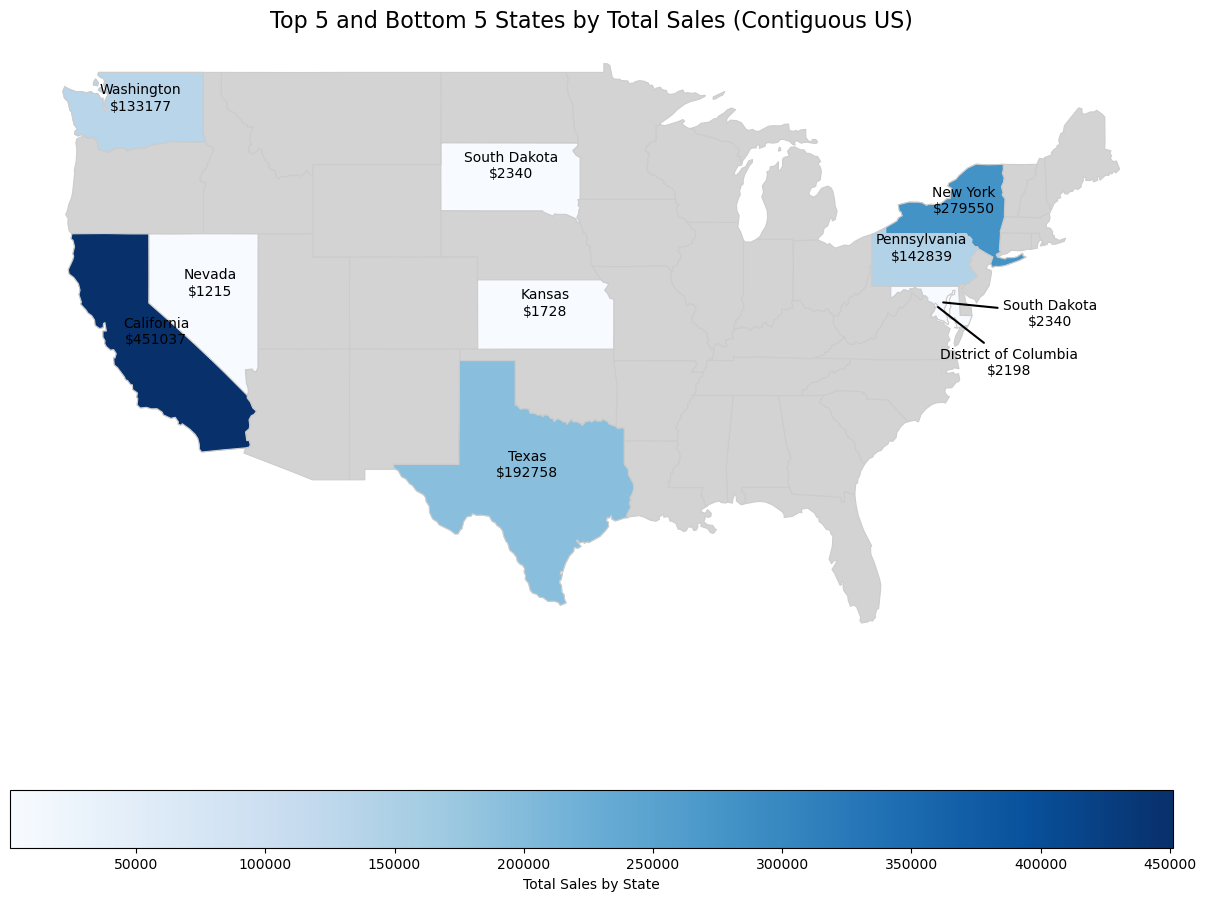

In [77]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt




# Get top 5 and bottom 5 states by sales
top_5 = sales_data.nlargest(5, 'total_sales')
bottom_5 = sales_data.nsmallest(5, 'total_sales')

# Combine top 5 and bottom 5 into a single DataFrame
selected_states = pd.concat([top_5, bottom_5])

# Load US states shapefile (GeoJSON for US states)
states = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')

# Filter out Alaska, Hawaii, and other non-contiguous areas
contiguous_states = states[~states['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# Merge the sales data with the GeoDataFrame
merged = contiguous_states.set_index('name').join(selected_states.set_index('State'))

# Create a new column for color; fill with 'lightgrey' for states without data
merged['color'] = merged['total_sales'].apply(lambda x: 'lightgrey' if pd.isna(x) else 'blue')

# Create a plot with matplotlib
fig, ax = plt.subplots(1, 1, figsize=(15, 12))  # Adjusted to make the map larger

# Plot the states, but color only those with 'total_sales' data
merged.plot(ax=ax, color='lightgrey', linewidth=0.8, edgecolor='0.8')  # Grey for other states

# Plot only the selected states (top 5 and bottom 5) with color mapping
merged[~merged['total_sales'].isna()].plot(column='total_sales', ax=ax, cmap='Blues', linewidth=0.8, edgecolor='0.8', 
                                           legend=True, legend_kwds={'label': "Total Sales by State", 
                                                                     'orientation': "horizontal"})

# Add labels for total_sales and state names on each state
for idx, row in merged.iterrows():
    if pd.notna(row['total_sales']) and idx not in ['Maryland', 'District of Columbia']:  # Skip South Dakota and DC
        ax.text(row['geometry'].centroid.x, row['geometry'].centroid.y, 
                f"{idx}\n${row['total_sales']:.0f}", fontsize=10, ha='center', color='black')

# Move South Dakota and District of Columbia labels outside the map
outside_labels = {
    'South Dakota': {'xy': (merged.loc['Maryland'].geometry.centroid.x, merged.loc['Maryland'].geometry.centroid.y),
                     'text': (merged.loc['Maryland'].geometry.centroid.x + 6, merged.loc['Maryland'].geometry.centroid.y - 1)},
    'District of Columbia': {'xy': (merged.loc['District of Columbia'].geometry.centroid.x, merged.loc['District of Columbia'].geometry.centroid.y),
                             'text': (merged.loc['District of Columbia'].geometry.centroid.x + 4, merged.loc['District of Columbia'].geometry.centroid.y - 3)}
}

for state, pos in outside_labels.items():
    # Draw the callout line
    ax.annotate(f"{state}\n${merged.loc[state, 'total_sales']:.0f}", 
                xy=pos['xy'],  # Coordinates of the state
                xytext=pos['text'],  # Position of the label outside
                textcoords='data',
                arrowprops=dict(facecolor='black', arrowstyle='-', lw=1.5),  # Line style
                fontsize=10, ha='center', color='black')

# Set the title
ax.set_title('Top 5 and Bottom 5 States by Total Sales (Contiguous US)', fontsize=16)

# Remove axes for cleaner visualization
ax.set_axis_off()

# Show the plot
plt.show()

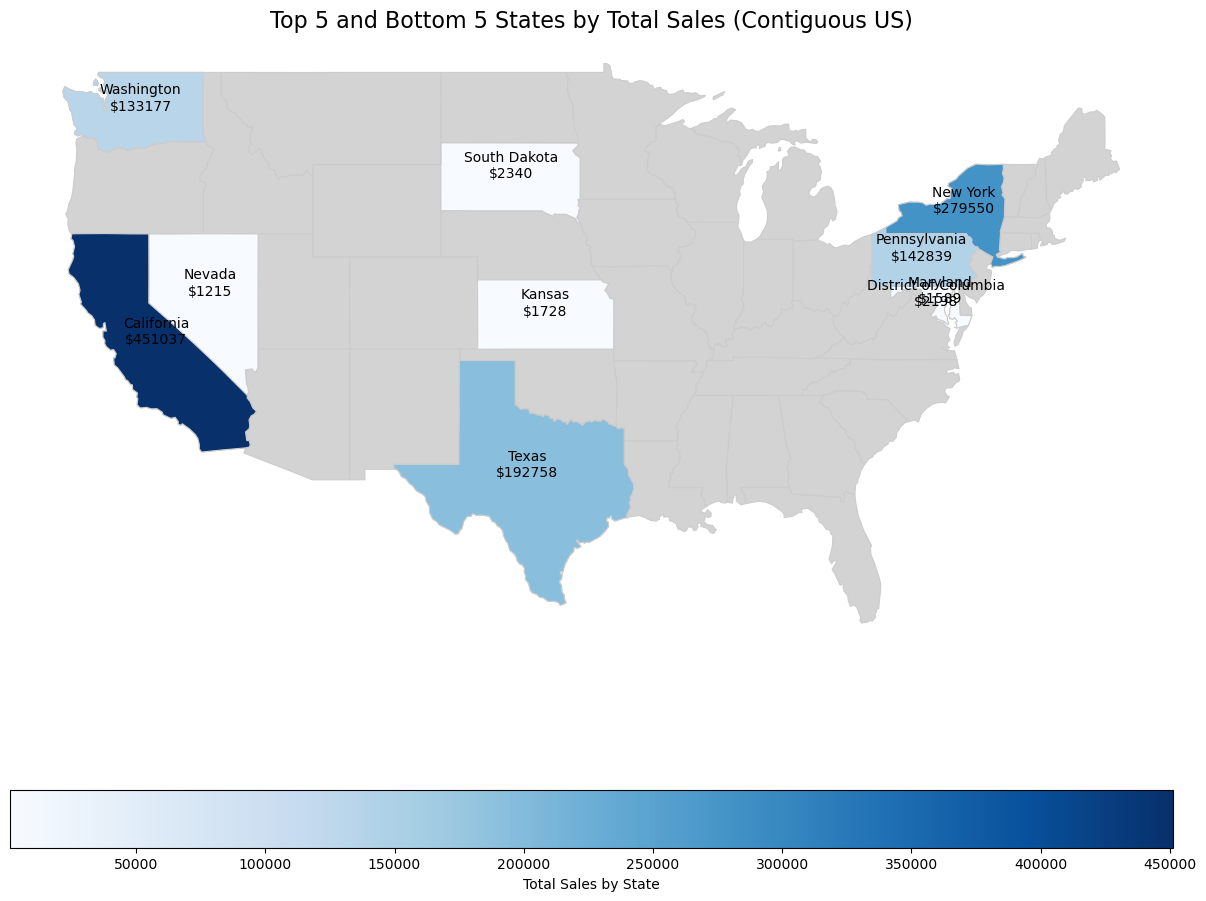

In [64]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Sample data: State and total sales (replace this with your actual dataset)
# sales_data = pd.DataFrame({
#     'State': ['California', 'New York', 'Texas', 'Pennsylvania', 'Washington', 
#               'Florida', 'Nevada', 'Arizona', 'Ohio', 'Idaho'],
#     'total_sales': [451036.5823, 279549.8235, 192758.2049, 142838.5510, 133177.2518,
#                     100000, 50000, 120000, 110000, 60000]  # Example sales data
# })

# Get top 5 and bottom 5 states by sales
top_5 = sales_data.nlargest(5, 'total_sales')
bottom_5 = sales_data.nsmallest(5, 'total_sales')

# Combine top 5 and bottom 5 into a single DataFrame
selected_states = pd.concat([top_5, bottom_5])

# Load US states shapefile (GeoJSON for US states)
states = gpd.read_file('https://raw.githubusercontent.com/PublicaMundi/MappingAPI/master/data/geojson/us-states.json')

# Filter out Alaska, Hawaii, and other non-contiguous areas
contiguous_states = states[~states['name'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

# Merge the sales data with the GeoDataFrame
merged = contiguous_states.set_index('name').join(selected_states.set_index('State'))

# Create a new column for color; fill with 'lightgrey' for states without data
merged['color'] = merged['total_sales'].apply(lambda x: 'lightgrey' if pd.isna(x) else 'blue')

# Create a plot with matplotlib
fig, ax = plt.subplots(1, 1, figsize=(15, 12))  # Adjusted to make the map larger

# Plot the states, but color only those with 'total_sales' data
merged.plot(ax=ax, color='lightgrey', linewidth=0.8, edgecolor='0.8')  # Grey for other states

# Plot only the selected states (top 5 and bottom 5) with color mapping
merged[~merged['total_sales'].isna()].plot(column='total_sales', ax=ax, cmap='Blues', linewidth=0.8, edgecolor='0.8', 
                                           legend=True, legend_kwds={'label': "Total Sales by State", 
                                                                     'orientation': "horizontal"})

# Add labels for total_sales and state names on each state
for idx, row in merged.iterrows():
    if pd.notna(row['total_sales']):
        # Add state name and sales value
        ax.text(row['geometry'].centroid.x, row['geometry'].centroid.y, 
                f"{idx}\n${row['total_sales']:.0f}", fontsize=10, ha='center', color='black')

# Set the title
ax.set_title('Top 5 and Bottom 5 States by Total Sales (Contiguous US)', fontsize=16)

# Remove axes for cleaner visualization
ax.set_axis_off()

# Show the plot
plt.show()